In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler #NORMALIZAÇÃO
from sklearn.model_selection import train_test_split, cross_val_score #SPLIT E CROSS VALIDATION
from sklearn.linear_model import LinearRegression, LassoCV, Ridge #REGRESSÃO LINEAR E REGULARIZAÇÃO L1(LASSO) E L2(RIDGE)
from sklearn.metrics import mean_squared_error #METRICA

import warnings
warnings.simplefilter('ignore')

In [85]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


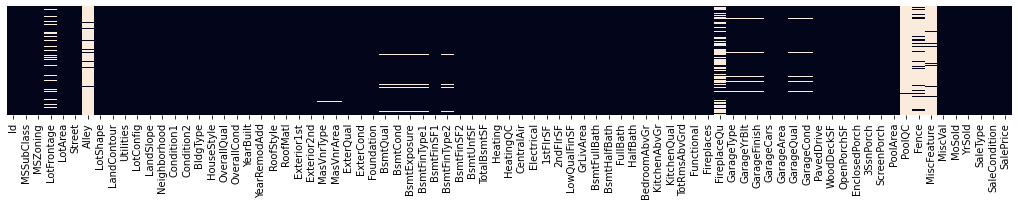

In [86]:
# Checando valores nulos
plt.figure(figsize=(18,2))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False);

De acordo com a descrição dos dados, os que são NaN são pq dependem de outra variavel que talvez seja 0, logo, podem ser phenchidas com 0.

E dessa forma, podemos fazer esse prenchimentos antes do split dos dados. Caso fosse necessario prencher com media, moda, mediana, é importante que essa etapa seja realizada apenas depois de dividir o dataset.


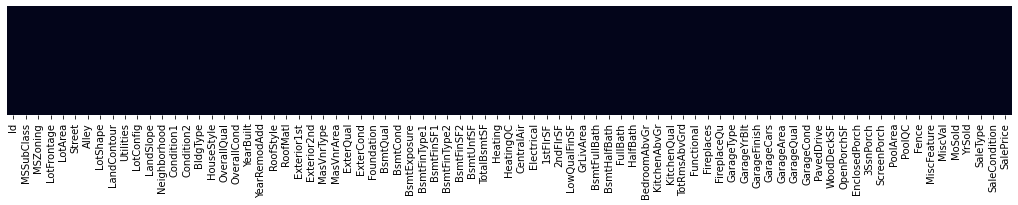

In [87]:
df.fillna(0, inplace=True)

plt.figure(figsize=(18,2))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False);

In [88]:
#Transformando os dados em numeros para a regressão
cols = df.select_dtypes(np.number).columns #seleciona todas as colunas que tem numero como dtype 
cols = cols.delete(-1) #como o target(SalePrice) tambem está aqui precisamos tirar ela (ultima coluna)
df[cols] = StandardScaler().fit_transform(df[cols]) # Normalização dos dados, pode fazer isso separado

df_new = pd.get_dummies(df, drop_first=True)

## Split de dados

In [120]:
#primeiro tiramos as colunas 'SalePrice' que será o target e 'Id' que não vai servir para modelagem
X = df_new.drop(['Id','SalePrice'], axis=1)

#transformamos o target para valores com menor "magnitude"
y = np.log10(df_new['SalePrice'])

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=12)

In [121]:
#criamos uma função para fazer Cross validation e retornar a raiz quadrada do erro medio do modelo
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring= 'neg_mean_squared_error', cv=5))
    
    return rmse

### Regressão Linear

Primeiro vamos realizar a regressão linear com todas as features do dataset

In [122]:
modelo_RL = LinearRegression()
modelo_RL.fit(Xtrain, ytrain)

LinearRegression()

In [123]:
rmse1 = rmse_cv(modelo_RL)
print(f'O erro do modelo foi de {rmse1.mean()}')

O erro do modelo foi de 2537868900.277308


### Regularização Ridge - L2
Nesse tipo de regularização temos o alpha que determina a penalização que ajusta os coeficientes

In [124]:
# Vamos testar alguns valores de alpha para ver seu impacto
alphas = [0.1, 0.5, 1, 3, 5, 10]
erro = [] 
for a in alphas:
    modelo_ridge = Ridge(alpha=a)
    modelo_ridge.fit(Xtrain, ytrain)
    rmse2 = rmse_cv(modelo_ridge)
    erro.append(rmse2.mean())

print(f'o erro do modelo foi de {round(np.mean(erro),4)}')

Ridge(alpha=0.1)

Ridge(alpha=0.5)

Ridge(alpha=1)

Ridge(alpha=3)

Ridge(alpha=5)

Ridge(alpha=10)

o erro do modelo foi de 0.0634


<AxesSubplot:>

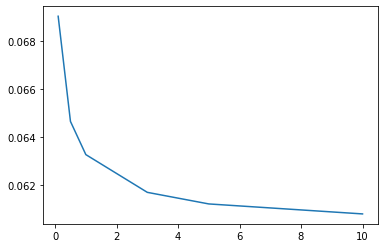

In [125]:
#plotando O RMSE de cada modelo de acordo com o alpha utilizado
cv_ridge = [rmse_cv(Ridge(alpha=a)).mean() for a in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot()

In [126]:
len(modelo_ridge.coef_[modelo_ridge.coef_ == 0])
# vemos que o metodo chegou a zerar 8 das features iniciais do modelo

2

### Regularização Lasso - L1

Nesse método temos o alpha que penaliza as features de menor importância e zera seu coeficiente

In [127]:
modelo_lasso = LassoCV(alphas = [0.000005, 0.001 , 0.1, 0.5, 1])
modelo_lasso.fit(Xtrain, ytrain)

LassoCV(alphas=[5e-06, 0.001, 0.1, 0.5, 1])

In [128]:
rmse3 = np.sqrt(-cross_val_score(modelo_lasso, X, y, scoring = 'neg_mean_squared_error', cv=5))

print(f'O erro do modelo foi de {round(rmse3.mean(),4)}')
#vemos que aqui o modelo teve um RMSE de 0.0631 comparado ao L2 que foi 0.0634

O erro do modelo foi de 0.0631


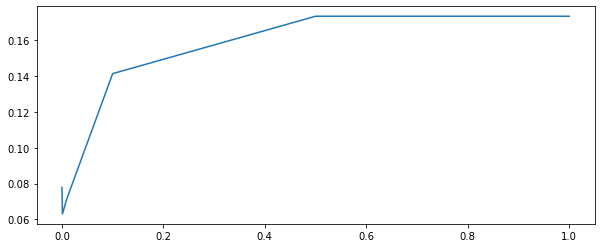

In [129]:
#plotando os erros do modelo de acordo com o alpha utilizado
alphas = [0.000005, 0.001 , 0.01, 0.1, 0.5, 1]
erro_lasso = [rmse_cv( LassoCV(alphas=[a]) ).mean() for a in alphas]
plt.figure(figsize=(10,4))
plt.plot(alphas,erro_lasso);

In [130]:
len(modelo_lasso.coef_[modelo_lasso.coef_ == 0.00])
#Veja que o método LASSO zerou mais de 210 coeficientes, fazendo uma seleção de atributos

206

### Validação

In [131]:
#regressção linear
predlm = modelo_RL.predict(Xtest)

#ridge
predridge = modelo_ridge.predict(Xtest)

#lasso
predlasso = modelo_lasso.predict(Xtest)

In [132]:
performance = pd.DataFrame({'Valor Y':ytest,
                            'Regressao': predlm, 
                            'DifReg': ytest-predlm, 
                            'Ridge': predridge, 
                            'DifRidge': ytest-predridge, 
                            'Lasso': predlasso, 
                            'DifLasso': ytest-predlasso})

In [137]:
pd.DataFrame([{'Erro Regressão': round(performance.DifReg.mean()),
                'Erro Ridge':round(10**performance.DifRidge.mean(),3), 
                'Erro Lasso': round(10** performance.DifLasso.mean(),3)}])

,Erro Regressão,Erro Ridge,Erro Lasso
0,8970,1.009,1.012
